# Tobamovirus Classification Model: Results Analysis

This notebook provides a comprehensive analysis of the machine learning pipeline results for tobamovirus classification. The analysis covers three main components:

1. Model Selection: Comparison of different algorithms
2. Model Evaluation: Performance assessment using different contig prediction methods
3. **Final Model**: Feature importance analysis and model characteristics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-ready figures
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Define paths (adjusted for notebook location in notebooks folder)
base_dir = Path('/home/tobamo/analize/project-tobamo/analysis/model')
results_dir = base_dir / 'results'
figures_dir = base_dir / 'figures'
model_selection_dir = results_dir / 'model_selection_test_n5'
evaluation_dir = results_dir / 'evaluation_results'
final_model_dir = results_dir / 'final_model'

# Create figures directory if it doesn't exist
figures_dir.mkdir(exist_ok=True)

## 4. Final Model Analysis

Analysis of the final trained model including feature importance and model characteristics.

In [2]:
# Load final model results
feature_importance = pd.read_csv(final_model_dir / 'top_40_features.csv')
all_features = pd.read_csv(final_model_dir / 'all_features.csv')

print(f"Total features in final model: {len(all_features)}")
print(f"Top 40 features analyzed: {len(feature_importance)}")
print(f"\nTop 10 most important features:")
print("=" * 50)
for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"{i+1:2d}. {row['Feature']:<40} {row['Importance']:.6f}")

Total features in final model: 148
Top 40 features analyzed: 40

Top 10 most important features:
 1. tobamo_orf1_identity_score_max           0.021722
 2. outgroup_orf1_identity_score_max         0.021600
 3. outgroup_orf2_identity_score_max         0.016309
 4. stop_codons                              0.016285
 5. outgroup_orf2_identity_score_mean        0.015451
 6. outgroup_orf2_identity_score_min         0.015112
 7. outgroup_orf1_N/aln_len_max              0.014921
 8. tobamo_orf1_N/aln_len_max                0.014522
 9. tobamo_orf1_gap_openings_min             0.014490
10. outgroup_orf2_gap_ratio_mean             0.013380


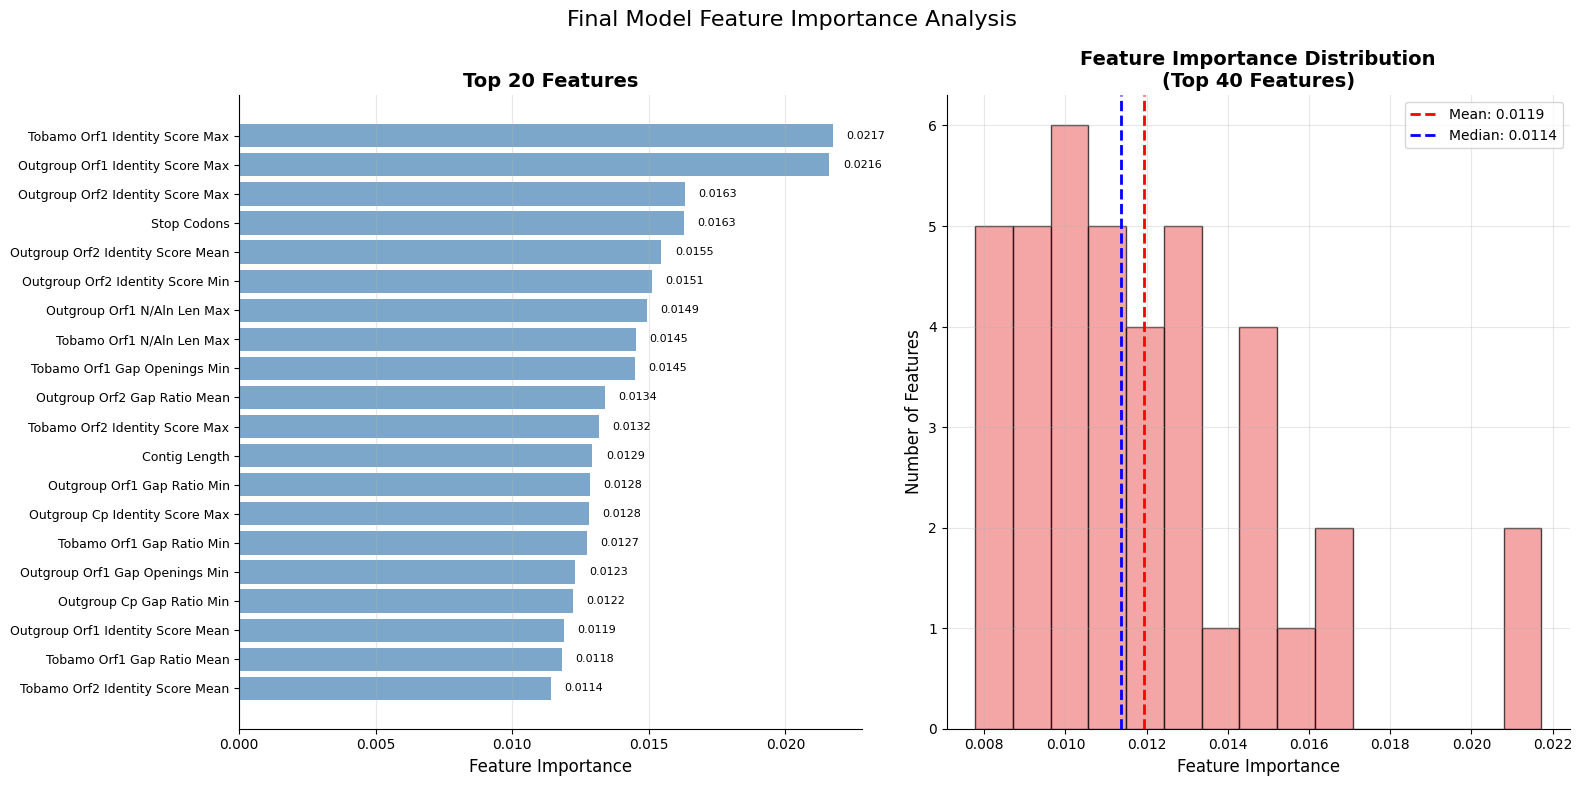

In [3]:
# Figure 4: Feature Importance Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Final Model Feature Importance Analysis', fontsize=16, y=0.98)

# Top 20 features horizontal bar plot
top_20 = feature_importance.head(20)
y_pos = np.arange(len(top_20))

bars = ax1.barh(y_pos, top_20['Importance'], color='steelblue', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f.replace('_', ' ').title() for f in top_20['Feature']], fontsize=9)
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 20 Features', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_20['Importance'])):
    ax1.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', ha='left', va='center', fontsize=8)

# Feature importance distribution
ax2.hist(feature_importance['Importance'], bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Feature Importance')
ax2.set_ylabel('Number of Features')
ax2.set_title('Feature Importance Distribution\n(Top 40 Features)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add statistics
mean_imp = feature_importance['Importance'].mean()
median_imp = feature_importance['Importance'].median()
ax2.axvline(mean_imp, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_imp:.4f}')
ax2.axvline(median_imp, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_imp:.4f}')
ax2.legend()

plt.tight_layout()
plt.savefig(figures_dir / 'Figure4_FeatureImportance.png', dpi=300, bbox_inches='tight')
plt.show()

Total alignment-related features in top 40: 40
Breakdown by metric type:
  Identity Score: 14 features
  Gap Ratio: 13 features
  N-ratio (N/aln_len): 5 features
  Gap Openings: 4 features
  Sequence Properties: 2 features
  Alignment Length: 2 features


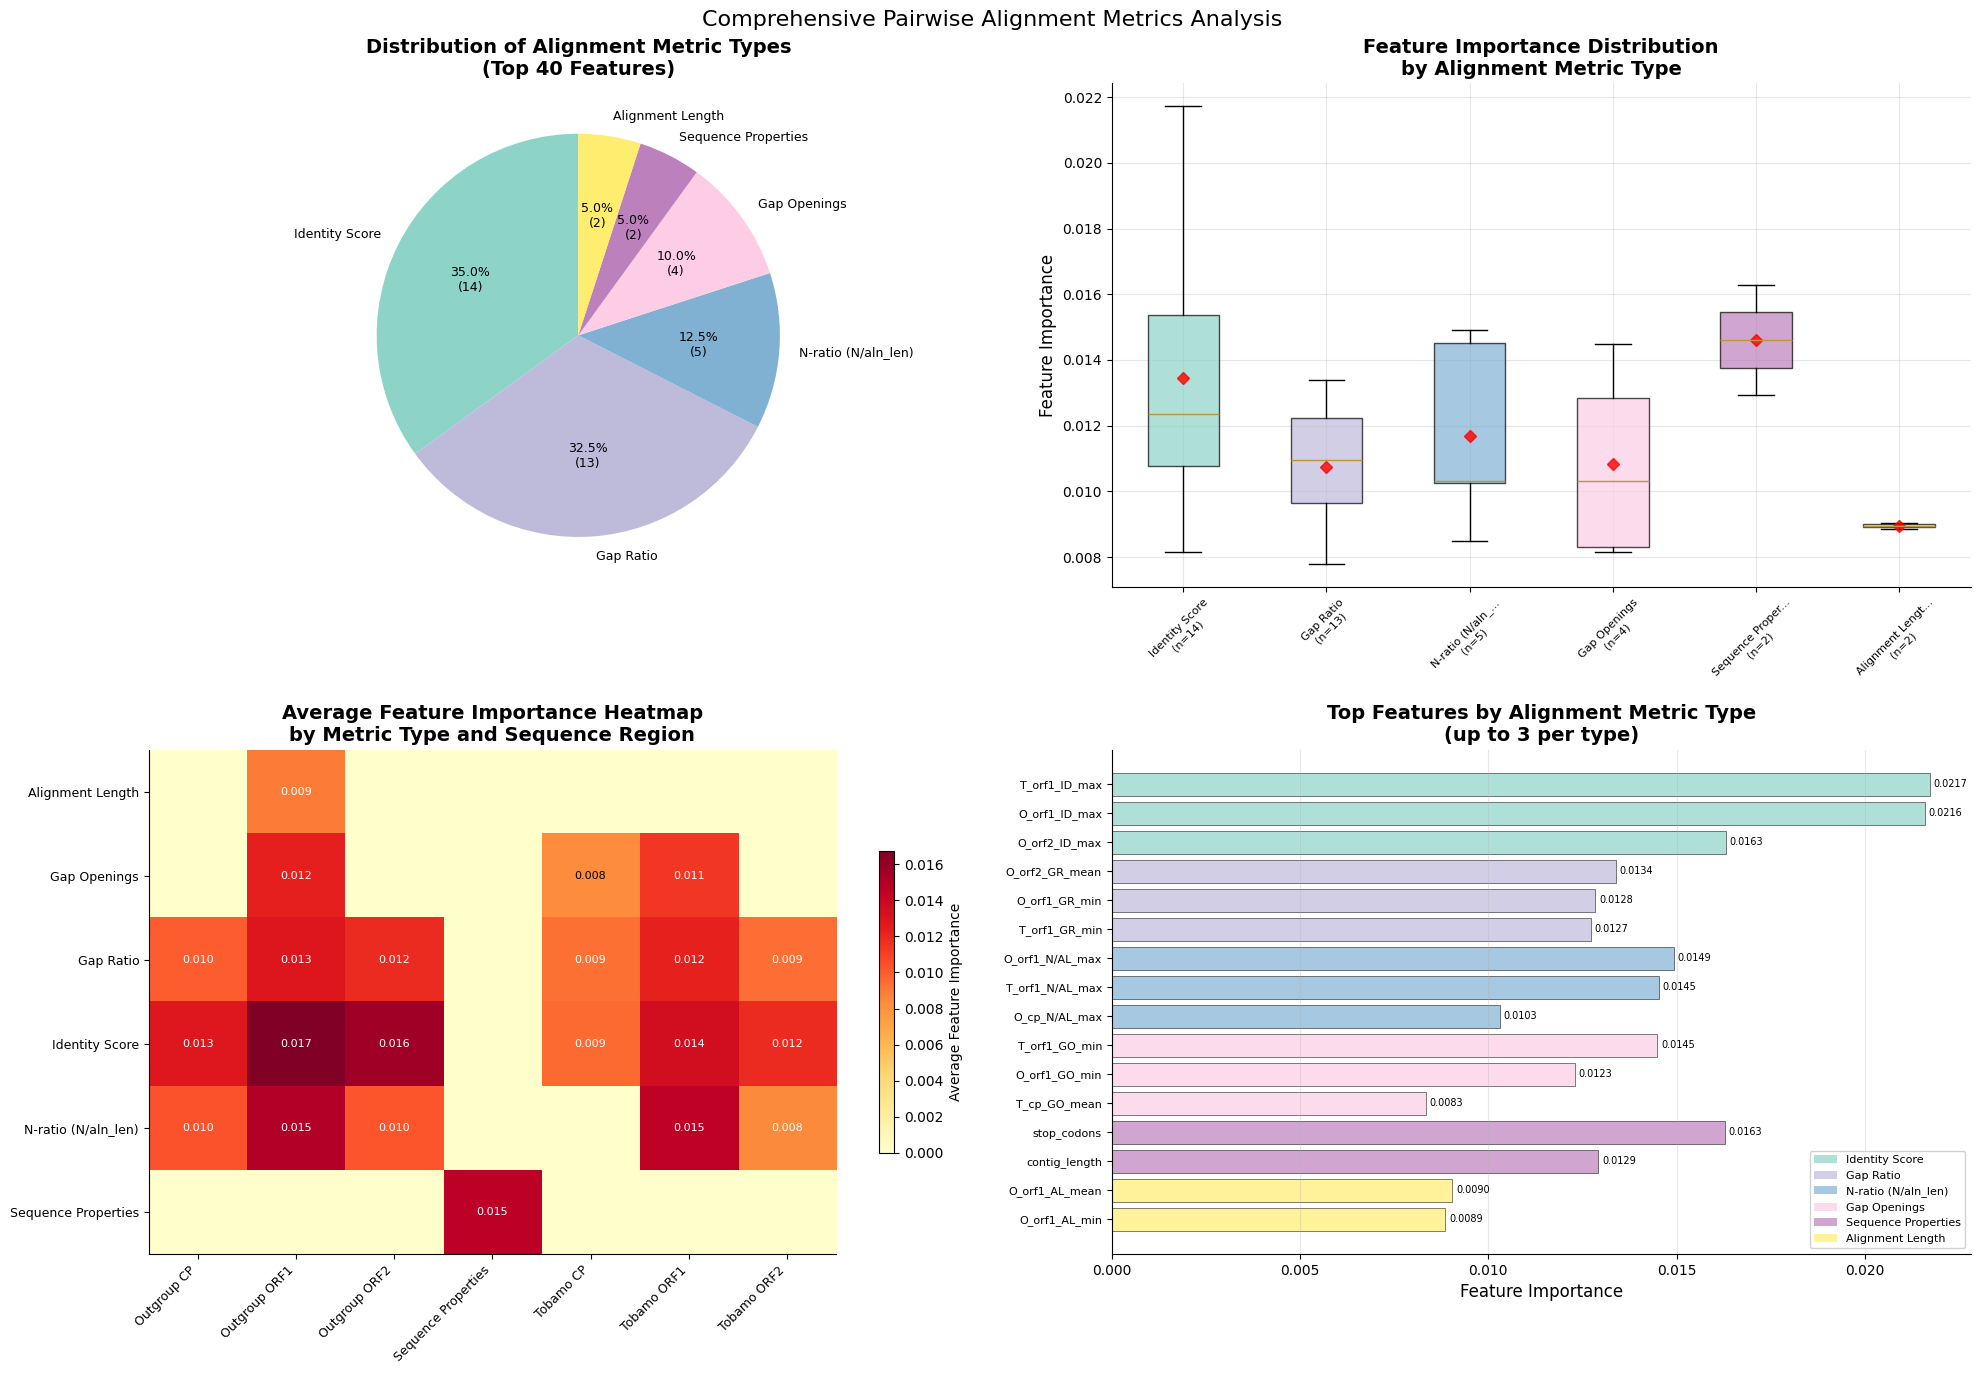


Comprehensive Alignment Metrics Analysis Summary:
                     Count      Mean       Std       Min       Max
Alignment_Metric                                                  
Alignment Length         2  0.008950  0.000135  0.008854  0.009045
Gap Openings             4  0.010823  0.003102  0.008158  0.014490
Gap Ratio               13  0.010755  0.001787  0.007774  0.013380
Identity Score          14  0.013450  0.004206  0.008152  0.021722
N-ratio (N/aln_len)      5  0.011695  0.002863  0.008474  0.014921
Sequence Properties      2  0.014603  0.002379  0.012920  0.016285

Overall Statistics:
Total alignment features: 40 out of 40 top features
Alignment features represent 100.0% of top features
Average importance of alignment features: 0.011925
Top alignment feature: tobamo_orf1_identity_score_max (0.021722)

Metric-Specific Insights:
  Identity Score: 14 features, top = tobamo_orf1_identity_score_max (0.021722)
  Gap Ratio: 13 features, top = outgroup_orf2_gap_ratio_mean (0.01

In [7]:
# Figure 6: Comprehensive Pairwise Alignment Metrics Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Comprehensive Pairwise Alignment Metrics Analysis', fontsize=16, y=0.98)

# Comprehensive categorization of features by alignment metric type
def categorize_alignment_metric(feature_name):
    # Identity score metrics
    if 'identity_score' in feature_name:
        return 'Identity Score'
    # Gap-related metrics
    elif 'gap_ratio' in feature_name:
        return 'Gap Ratio'
    elif 'gap_openings' in feature_name:
        return 'Gap Openings'
    # Length and ratio metrics
    elif 'aln_len' in feature_name and 'N/aln_len' not in feature_name:
        return 'Alignment Length'
    elif 'aln_orf_len' in feature_name:
        return 'ORF Alignment Length'
    elif 'N/aln_len' in feature_name:
        return 'N-ratio (N/aln_len)'
    # Count metrics
    elif feature_name.endswith('_M_min') or feature_name.endswith('_M_max') or feature_name.endswith('_M_mean'):
        return 'Match Count (M)'
    elif feature_name.endswith('_N_min') or feature_name.endswith('_N_max') or feature_name.endswith('_N_mean'):
        return 'Mismatch Count (N)'
    # Sequence properties
    elif feature_name in ['stop_codons', 'contig_length']:
        return 'Sequence Properties'
    else:
        return 'Other'

# Apply categorization
feature_importance['Alignment_Metric'] = feature_importance['Feature'].apply(categorize_alignment_metric)

# Filter all alignment-related features for detailed analysis (including sequence properties)
alignment_features = feature_importance[
    feature_importance['Alignment_Metric'].isin([
        'Identity Score', 'Gap Ratio', 'Gap Openings', 'Alignment Length', 
        'ORF Alignment Length', 'N-ratio (N/aln_len)', 'Match Count (M)', 
        'Mismatch Count (N)', 'Sequence Properties'
    ])
].copy()

print(f"Total alignment-related features in top 40: {len(alignment_features)}")
print(f"Breakdown by metric type:")
metric_breakdown = alignment_features['Alignment_Metric'].value_counts()
for metric, count in metric_breakdown.items():
    print(f"  {metric}: {count} features")

# 1. Enhanced pie chart of alignment metric types
metric_counts = alignment_features['Alignment_Metric'].value_counts()
colors_metrics = plt.cm.Set3(np.linspace(0, 1, len(metric_counts)))

# Create pie chart with better formatting
wedges, texts, autotexts = ax1.pie(metric_counts.values, 
                                  labels=metric_counts.index,
                                  autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*len(alignment_features))})',
                                  colors=colors_metrics,
                                  startangle=90,
                                  textprops={'fontsize': 9})
ax1.set_title('Distribution of Alignment Metric Types\n(Top 40 Features)', fontweight='bold')

# 2. Enhanced box plot with statistical annotations
metric_importance = []
metric_labels = []
metric_stats = []

for metric in metric_counts.index:
    values = alignment_features[alignment_features['Alignment_Metric'] == metric]['Importance'].values
    metric_importance.append(values)
    metric_labels.append(f"{metric[:15]}...\n(n={len(values)})" if len(metric) > 15 else f"{metric}\n(n={len(values)})")
    metric_stats.append({
        'mean': np.mean(values),
        'median': np.median(values),
        'std': np.std(values)
    })

bp = ax2.boxplot(metric_importance, labels=metric_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_metrics):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('Feature Importance')
ax2.set_title('Feature Importance Distribution\nby Alignment Metric Type', fontweight='bold')
ax2.tick_params(axis='x', rotation=45, labelsize=8)
ax2.grid(True, alpha=0.3)

# Add mean markers
for i, stats in enumerate(metric_stats):
    ax2.plot(i+1, stats['mean'], marker='D', color='red', markersize=6, alpha=0.8)

# 3. Enhanced heatmap showing all alignment metrics by sequence type
def extract_detailed_info(feature_name):
    if feature_name in ['stop_codons', 'contig_length']:
        return 'Sequence Properties', 'Global', 'Single'
    
    if feature_name.startswith('tobamo_'):
        seq_type = 'Tobamo'
        remaining = feature_name.replace('tobamo_', '')
    elif feature_name.startswith('outgroup_'):
        seq_type = 'Outgroup'
        remaining = feature_name.replace('outgroup_', '')
    else:
        return 'Other', 'Other', 'Other'
    
    # Extract region
    if remaining.startswith('orf1_'):
        region = 'ORF1'
        remaining = remaining.replace('orf1_', '')
    elif remaining.startswith('orf2_'):
        region = 'ORF2'
        remaining = remaining.replace('orf2_', '')
    elif remaining.startswith('cp_'):
        region = 'CP'
        remaining = remaining.replace('cp_', '')
    else:
        region = 'Other'
    
    # Extract statistic
    if remaining.endswith('_max'):
        stat = 'Max'
    elif remaining.endswith('_min'):
        stat = 'Min'
    elif remaining.endswith('_mean'):
        stat = 'Mean'
    else:
        stat = 'Other'
    
    return seq_type, region, stat

# Create comprehensive heatmap data
alignment_features['Seq_Type'] = alignment_features['Feature'].apply(lambda x: extract_detailed_info(x)[0])
alignment_features['Region'] = alignment_features['Feature'].apply(lambda x: extract_detailed_info(x)[1])
alignment_features['Statistic'] = alignment_features['Feature'].apply(lambda x: extract_detailed_info(x)[2])
alignment_features['Combined_Label'] = alignment_features.apply(
    lambda row: f"{row['Seq_Type']} {row['Region']}" if row['Seq_Type'] != 'Sequence Properties' 
    else row['Seq_Type'], axis=1
)

# Create pivot table for comprehensive heatmap
heatmap_data = alignment_features.pivot_table(
    values='Importance', 
    index='Alignment_Metric', 
    columns='Combined_Label', 
    aggfunc='mean',  # Average if multiple features in same category
    fill_value=0
)

# Create heatmap
im = ax3.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
ax3.set_xticks(range(len(heatmap_data.columns)))
ax3.set_xticklabels(heatmap_data.columns, rotation=45, ha='right', fontsize=9)
ax3.set_yticks(range(len(heatmap_data.index)))
ax3.set_yticklabels(heatmap_data.index, fontsize=9)
ax3.set_title('Average Feature Importance Heatmap\nby Metric Type and Sequence Region', fontweight='bold')

# Add text annotations for non-zero values
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        value = heatmap_data.iloc[i, j]
        if value > 0:
            ax3.text(j, i, f'{value:.3f}', ha='center', va='center', 
                    color='white' if value > heatmap_data.values.max()/2 else 'black',
                    fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.6)
cbar.set_label('Average Feature Importance', fontsize=10)

# 4. Comprehensive ranking of top features by alignment metric
# Get top 3 features per metric type (or all if fewer than 3)
top_features_by_metric = []
for metric in metric_counts.index:
    metric_features = alignment_features[alignment_features['Alignment_Metric'] == metric]
    metric_features_sorted = metric_features.nlargest(min(3, len(metric_features)), 'Importance')
    top_features_by_metric.append(metric_features_sorted)

top_by_metric = pd.concat(top_features_by_metric, ignore_index=True)

# Create horizontal bar plot with improved labeling
y_positions = np.arange(len(top_by_metric))
feature_names = []
importances = top_by_metric['Importance'].values
colors_bars = []

for _, row in top_by_metric.iterrows():
    # Create simplified but informative feature names
    original_name = row['Feature']
    if 'tobamo_' in original_name:
        simplified = original_name.replace('tobamo_', 'T_')
    elif 'outgroup_' in original_name:
        simplified = original_name.replace('outgroup_', 'O_')
    else:
        simplified = original_name
    
    # Further simplifications for readability
    simplified = simplified.replace('identity_score', 'ID')
    simplified = simplified.replace('gap_ratio', 'GR')
    simplified = simplified.replace('gap_openings', 'GO')
    simplified = simplified.replace('aln_len', 'AL')
    simplified = simplified.replace('aln_orf_len', 'AOL')
    simplified = simplified.replace('N/aln_len', 'N/AL')
    
    feature_names.append(simplified)
    
    # Color by metric type
    metric_type = row['Alignment_Metric']
    color_idx = list(metric_counts.index).index(metric_type)
    colors_bars.append(colors_metrics[color_idx])

bars = ax4.barh(y_positions, importances, color=colors_bars, alpha=0.7, edgecolor='black', linewidth=0.5)
ax4.set_yticks(y_positions)
ax4.set_yticklabels(feature_names, fontsize=8)
ax4.set_xlabel('Feature Importance')
ax4.set_title('Top Features by Alignment Metric Type\n(up to 3 per type)', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')
ax4.invert_yaxis()

# Add importance value labels
for bar, importance in zip(bars, importances):
    ax4.text(bar.get_width() + 0.0001, bar.get_y() + bar.get_height()/2,
            f'{importance:.4f}', ha='left', va='center', fontsize=7)

# Add legend for metric types
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors_metrics[i], alpha=0.7, 
                                label=metric) for i, metric in enumerate(metric_counts.index)]
ax4.legend(handles=legend_elements, loc='lower right', fontsize=8, framealpha=0.9)

plt.tight_layout()
plt.savefig(figures_dir / 'Figure6_ComprehensiveAlignmentMetrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comprehensive statistics
print("\nComprehensive Alignment Metrics Analysis Summary:")
print("=" * 70)

# Detailed breakdown by metric type
alignment_summary = alignment_features.groupby('Alignment_Metric').agg({
    'Importance': ['count', 'mean', 'std', 'min', 'max']
}).round(6)
alignment_summary.columns = ['Count', 'Mean', 'Std', 'Min', 'Max']
print(alignment_summary)

print(f"\nOverall Statistics:")
print(f"Total alignment features: {len(alignment_features)} out of {len(feature_importance)} top features")
print(f"Alignment features represent {len(alignment_features)/len(feature_importance)*100:.1f}% of top features")
print(f"Average importance of alignment features: {alignment_features['Importance'].mean():.6f}")
print(f"Top alignment feature: {alignment_features.iloc[0]['Feature']} ({alignment_features.iloc[0]['Importance']:.6f})")

# Print metric-specific insights
print(f"\nMetric-Specific Insights:")
for metric in metric_counts.index:
    metric_data = alignment_features[alignment_features['Alignment_Metric'] == metric]
    top_feature = metric_data.nlargest(1, 'Importance')
    print(f"  {metric}: {len(metric_data)} features, "
          f"top = {top_feature.iloc[0]['Feature']} ({top_feature.iloc[0]['Importance']:.6f})")

# Sequence type analysis
print(f"\nSequence Type Analysis:")
seq_type_summary = alignment_features.groupby('Seq_Type')['Importance'].agg(['count', 'mean']).round(6)
for seq_type, stats in seq_type_summary.iterrows():
    print(f"  {seq_type}: {stats['count']} features, avg importance = {stats['mean']:.6f}")

# Statistical summary of all alignment metrics
print(f"\nStatistical Pattern Summary:")
stat_summary = alignment_features.groupby('Statistic')['Importance'].agg(['count', 'mean']).round(6)
for stat, stats in stat_summary.iterrows():
    if stat != 'Single':  # Skip single values
        print(f"  {stat} statistics: {stats['count']} features, avg importance = {stats['mean']:.6f}")